<a href="https://colab.research.google.com/github/forowho/Dendritic-and-non_Dendritic-Micrograph-Classification/blob/main/Copy_of_xxx_3_Dendritic_and_non_Dendritic_Augmtd__model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import keras
import os
import glob

%matplotlib inline
import shutil
from shutil import copyfile
import random
import time
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNeighborClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Import dataset from source website

In [2]:
# Download dataset
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip

--2024-10-19 18:04:54--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nyb6mycvfd-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.72.122, 3.5.72.164, 52.218.120.186, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.72.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111332105 (106M) [application/octet-stream]
Saving to: ‘nyb6mycvfd-1.zip’

nyb6mycvfd-1.zip    100%[===================>] 106.17M  22.8MB/s    in 6.0s    

2024-10-19 18:05:01 (17.7 MB/s) - ‘nyb6mycvfd-1.zip’ saved [111332105/111332105]



In [3]:
#unzip the dataset
!unzip -q /content/nyb6mycvfd-1.zip

# Image augmentation

In [4]:
# tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
#from tensorflow.keras.utils import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range =15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         rescale=1./255,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip = True,
                         fill_mode = 'nearest',
                         data_format='channels_last',
                         brightness_range=[0.5, 1.5])

#Data Aumentation

In [6]:
# prompt: generate code to create two folders and name it Augment_Dendrite and Augment_Non_Dendrite

try:
  os.mkdir('Augment_Dendrite')
except:
  print("Folder already exists")

try:
  os.mkdir('Augment_Non_Dendrite')
except:
  print("Folder already exists")

In [7]:
img_dir_Den = "/content/Dendritic" # Enter Directory of all images
data_path = os.path.join(img_dir_Den,'*g')
files = glob.glob(data_path)
data = []
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break


In [8]:
img_dir_Non_Den = "/content/Non-Dendritic" # Enter Directory of all images
data_path_N = os.path.join(img_dir_Non_Den,'*g')
files = glob.glob(data_path_N)
data_N = []
for f1 in files:
    img = cv2.imread(f1)
    data_N.append(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    i = 0
    path, dirs, files = next(os.walk("/content/Non-Dendritic"))
    file_count = len(files) #to find number of files in folder

    for batch in datagen.flow (x, batch_size=1, save_to_dir =r'/content/Augment_Non_Dendrite',save_prefix="a",save_format='jpg'):
      i+=1
      if i>20:
        break

In [9]:
# set path to dendritic micrograph images
dendritic_dir = '/content/Augment_Dendrite'
# set path to non dendritic micrograph images
non_dendritic_dir = '/content/Augment_Non_Dendrite'

#Print the total number of images in each directory
print("The total number of dendritic images are", len(os.listdir(dendritic_dir)))
print("The total number of non dendritic images are", len(os.listdir(non_dendritic_dir)))

The total number of dendritic images are 2150
The total number of non dendritic images are 5659


Step 2: Features extraction with histogram of oriented gradient (HOG)

In [10]:
# Paths to the dataset
dendritic_folder = "/content/Augment_Dendrite"
non_dendritic_folder = "/content/Augment_Non_Dendrite"

In [11]:

def extract_hog_features(image):
    # Convert the image to grayscale for HOG
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Resize the image to a fixed size for consistent HOG feature size
    resized_image = cv2.resize(gray_image, (64, 64)) # Resize to 64x64
    # Extract HOG features
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features

def load_dataset_and_extract_features():
    data = []
    labels = []
    # Process dendritic images
    for img_name in os.listdir(dendritic_folder):
        img_path = os.path.join(dendritic_folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            features = extract_hog_features(image)
            data.append(features)
            labels.append(1)  # 1 for Dendritic
    # Process non-dendritic images
    for img_name in os.listdir(non_dendritic_folder):
        img_path = os.path.join(non_dendritic_folder, img_name)
        image = cv2.imread(img_path)
        if image is not None:
            features = extract_hog_features(image)
            data.append(features)
            labels.append(0)  # 0 for Non-Dendritic
    return np.array(data), np.array(labels)

#Step 4: Train Test Split

In [12]:
X, Y = load_dataset_and_extract_features()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify = Y, random_state=42)

print(X.shape, X_train.shape, X_test.shape)

(7809, 1764) (6247, 1764) (1562, 1764)


#Step 5: Comparing the performance of models
* LogisticRegression()
* SVC(kernel='linear')
* KNeighborClassifier()
* RandomForestClassifier()

## Cross validation

In [13]:
models = [LogisticRegression(max_iter=1000), SVC(kernel='linear'), KNeighborClassifier(), RandomForestClassifier()]

def compare_models_train_test():
  for model in models:
    cv_score = cross_val_score(model, X, Y, cv=5)
    #evaluate the model
    mean_accuracy = sum(cv_score)/len(cv_score)
    mean_accuracy = mean_accuracy*100
    mean_accuracy = round(mean_accuracy, 2)
    print('Accuracy score of the ', model, ': ', mean_accuracy, '%')

compare_models_train_test()

Accuracy score of the  LogisticRegression(max_iter=1000) :  68.7 %
Accuracy score of the  SVC(kernel='linear') :  72.37 %
Accuracy score of the  KNeighborsClassifier() :  68.17 %
Accuracy score of the  RandomForestClassifier() :  72.44 %


Training Accuracy for LogisticRegression(max_iter=1000): 75.06%
Validation Accuracy for LogisticRegression(max_iter=1000): 70.81%


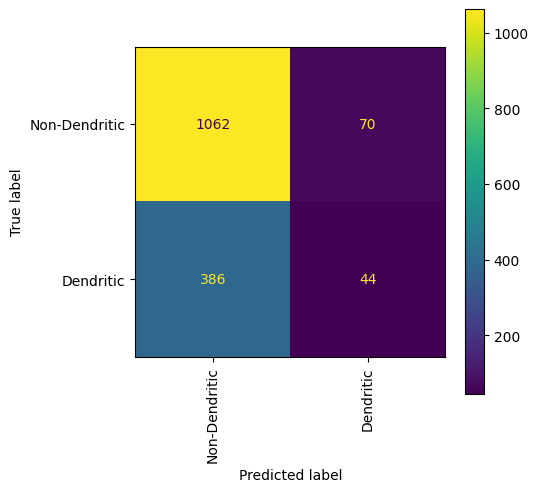

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1132
           1       0.39      0.10      0.16       430

    accuracy                           0.71      1562
   macro avg       0.56      0.52      0.49      1562
weighted avg       0.64      0.71      0.64      1562

Training Accuracy for SVC(kernel='linear'): 72.8%
Validation Accuracy for SVC(kernel='linear'): 72.47%


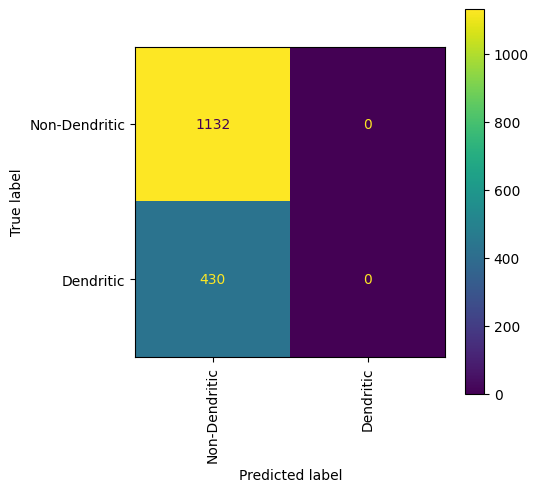

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1132
           1       0.00      0.00      0.00       430

    accuracy                           0.72      1562
   macro avg       0.36      0.50      0.42      1562
weighted avg       0.53      0.72      0.61      1562

Training Accuracy for KNeighborsClassifier(): 78.57%
Validation Accuracy for KNeighborsClassifier(): 68.63%


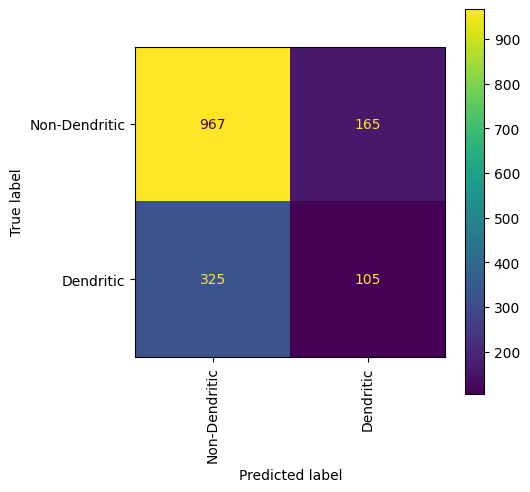

              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1132
           1       0.39      0.24      0.30       430

    accuracy                           0.69      1562
   macro avg       0.57      0.55      0.55      1562
weighted avg       0.65      0.69      0.66      1562

Training Accuracy for RandomForestClassifier(): 100.0%
Validation Accuracy for RandomForestClassifier(): 72.54%


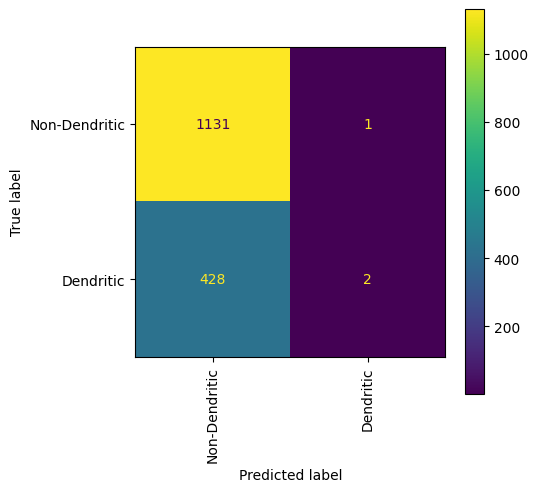

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1132
           1       0.67      0.00      0.01       430

    accuracy                           0.73      1562
   macro avg       0.70      0.50      0.42      1562
weighted avg       0.71      0.73      0.61      1562



In [14]:
# Metrics Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

models = [LogisticRegression(max_iter=1000), SVC(kernel='linear'), KNeighborClassifier(), RandomForestClassifier()]

def plot_confusion_matrix(y_val, y_pred, label):
    '''function to plot confusion matrix

    Args
    y_val: array. The validation set of the target variable.
    y_pred: array. Model's prediction.
    label: list. A list containing all the classes in the target variable

    Returns
    It returns a plot of the confusion matrix
    '''
    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(5,5))
    ConfusionMatrixDisplay(cm, display_labels=label).plot(ax=ax, values_format='', xticks_rotation='vertical')
    plt.show()

# class labels
label = ['Non-Dendritic', 'Dendritic']
RANDOM_STATE = 1

def compare_models_train_test():
  for model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Evaluate the model on training data
    train_predictions = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_accuracy = train_accuracy*100
    train_accuracy = round(train_accuracy, 2)
    print(f"Training Accuracy for {model}: {train_accuracy}%")

    # Evaluate the model on validation data
    val_predictions = model.predict(X_test)
    val_accuracy = accuracy_score(y_test, val_predictions)
    val_accuracy = val_accuracy*100
    val_accuracy = round(val_accuracy, 2)
    print(f"Validation Accuracy for {model}: {val_accuracy}%")

    # Confusion matrix
    plot_confusion_matrix(y_test, val_predictions, label)
    print(classification_report(y_test, val_predictions))

compare_models_train_test()